## Robust Local Fréchet Regression

This notebook explains how to estimate (denoise) the underlying true distribution with simulated data using UOTReg.

- **Note:** Before running any code cells, please update the paths in the notebook so they point to your local copy of the **UOTReg** folder.

In [1]:
# Change this to the path to your folder
result_folder = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'

In [2]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
os.chdir(result_folder)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np
import random
import math
from typing import Tuple

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import AdvInitialize, train_vae, optimize_T_and_D, optimize_G, optimize_T_and_D_UOT, optimize_T_and_D_UOT_new

# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


## Constucting dataset

500
500
500
500
500
500
500
500
500
500


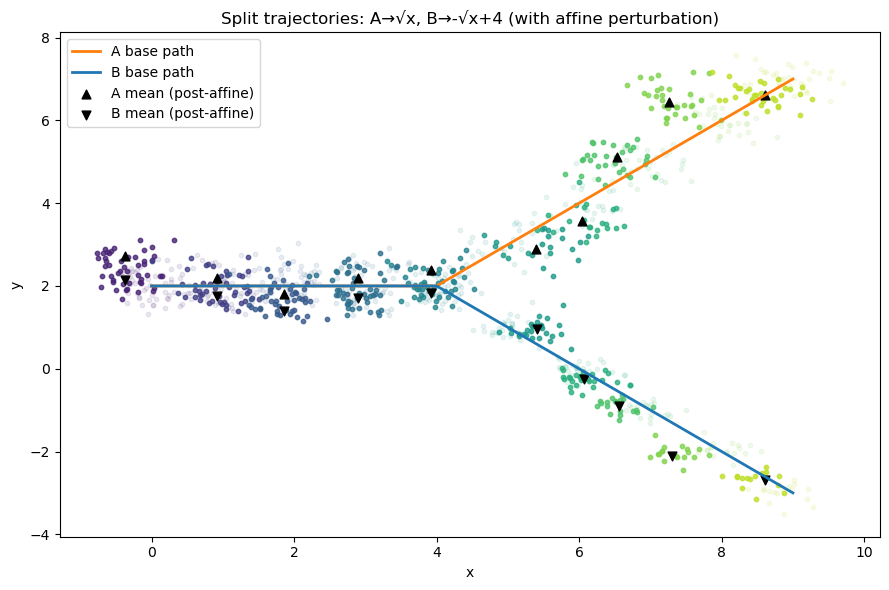

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# ---------------------- Affine (one-knob strength) --------------------------

def make_affine(strength=0.50, rotation_max_deg=10, scale_max=0.20, b_sigma_max=0.30):
    """
    Generate an affine map (A,b) with controllable 'strength':
      strength=0  -> A≈I, b≈0
      strength=1  -> full ranges of rotation/scale/translation
    """
    th = np.deg2rad(np.random.uniform(-rotation_max_deg*strength, rotation_max_deg*strength))
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, -s], [s, c]])

    s1 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)
    s2 = 1.0 + strength*np.random.uniform(-scale_max, scale_max)

    A  = R @ np.diag([s1, s2]) @ R.T
    b  = np.random.randn(2) * (b_sigma_max*strength)
    return A, b

# ---------------------- Configuration ---------------------------------------

seed = 23
np.random.seed(seed)

x   = np.arange(10)              # 0..9
NUM = len(x)
# Smooth reference line
x_fine = np.linspace(0, 9, 200)
y_fine = np.sqrt(x_fine)

yA_base = np.where(x <= 4, 2.0, x - 2)        # upper comp path
yB_base = np.where(x <= 4, 2.0, -x + 6.0) # lower comp path

colors = plt.cm.viridis(np.linspace(0.1, 0.9, NUM))

n_per_gauss  = 50
dataset_size = 500
pi_A         = 0.5

delta_pre  = 0.25
delta_post = 0.00

# >>> changed jitter logic
# Remove x-jitter entirely; only add small y-only jitter for t in {0..4}.
y_only_jitter_pre = 0.03  # magnitude for the early shared phase

sig_x_A, sig_y_A = 0.32, 0.30
sig_x_B, sig_y_B = 0.22, 0.20
cov_A = np.diag([sig_x_A**2, sig_y_A**2])
cov_B = np.diag([sig_x_B**2, sig_y_B**2])

strength = 0.5
per_time_affine = True

datasets_acc = []
Ysamplers_acc = []

# ---------------------- Main generation loop --------------------------------

plt.close('all')
plt.figure(figsize=(9, 6))
plt.title('Split trajectories: A→√x, B→-√x+4 (with affine perturbation)')

plt.plot(x, yA_base, color='tab:orange', linewidth=2.0, label='A base path')
plt.plot(x, yB_base, color='tab:blue',   linewidth=2.0, label='B base path')

datasets_acc = []

if not per_time_affine:
    A_global, b_global = make_affine(strength=strength)

for i in range(NUM):
    muA_center = np.array([x[i], yA_base[i]])
    muB_center = np.array([x[i], yB_base[i]])

    dA = +delta_pre  if i <= 4 else +delta_post
    dB = -delta_pre  if i <= 4 else -delta_post

    # >>> changed jitter logic (no x-jitter; only y-perturbation for t<=4)
    if i <= 4:
        jitter_y_A = np.random.randn() * y_only_jitter_pre
        jitter_y_B = np.random.randn() * y_only_jitter_pre
    else:
        jitter_y_A = 0.0
        jitter_y_B = 0.0

    mu_A = muA_center + np.array([0.0, dA + jitter_y_A])
    mu_B = muB_center + np.array([0.0, dB - jitter_y_B])  # keep B slightly lower

    counts_small = np.random.multinomial(n_per_gauss, [pi_A, 1 - pi_A])
    gt_A_small = np.random.multivariate_normal(mu_A, cov_A, counts_small[0])
    gt_B_small = np.random.multivariate_normal(mu_B, cov_B, counts_small[1])
    gt_small   = np.vstack([gt_A_small, gt_B_small])

    counts_full = np.random.multinomial(dataset_size, [pi_A, 1 - pi_A])
    gt_A = np.random.multivariate_normal(mu_A, cov_A, counts_full[0])
    gt_B = np.random.multivariate_normal(mu_B, cov_B, counts_full[1])
    gt_data = np.vstack([gt_A, gt_B])
    comp_full = np.array([0]*counts_full[0] + [1]*counts_full[1])

    if per_time_affine:
        A, b = make_affine(strength=strength)
    else:
        A, b = A_global, b_global

    pt_small = (gt_small @ A.T) + b
    pt_data  = (gt_data  @ A.T) + b

    datasets_acc.append(torch.from_numpy(pt_data).float())
    meta_acc= pd.DataFrame(i, index=range(dataset_size), columns=['value'])
    dataset = tensorDataset(pd.DataFrame(pt_data),meta_acc)
    print(len(dataset))
    Ysamplers_acc.append(tensorSampler(dataset, device="cpu"))

    mu_pt_A = A @ mu_A + b
    mu_pt_B = A @ mu_B + b

    col = colors[i]
    plt.scatter(gt_small[:,0], gt_small[:,1], color=col, s=10, alpha=0.10)
    plt.scatter(pt_small[:,0], pt_small[:,1], color=col, s=10, alpha=0.80)

    if i == 0:
        plt.scatter(*mu_pt_A, color='black', marker='^', s=40, label='A mean (post-affine)')
        plt.scatter(*mu_pt_B, color='black', marker='v', s=40, label='B mean (post-affine)')
    else:
        plt.scatter(*mu_pt_A, color='black', marker='^', s=40)
        plt.scatter(*mu_pt_B, color='black', marker='v', s=40)

plt.legend()
plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout()
plt.show()


## Calculate weights

- `tlist` represents the observed time points, while `age` specifies the time at which you want to estimate the distribution.

In [4]:
# set up the coefficient according to local Frechet
tlist = np.linspace(0,9,10)
print(tlist)
age = 1
print("Age to predict: {}".format(age))

# Bandwidth selection - Silverman's rule of thumb for Gaussian kernel
std_dev = np.std(tlist)
# h = 1.06 * std_dev * len(tlist) ** (-1/5)
h = 1

# Local Frechet coefficient
# Calculate moments
mu_0 = calculate_moments(tlist, age, h, 0)
mu_1 = calculate_moments(tlist, age, h, 1)
mu_2 = calculate_moments(tlist, age, h, 2)

# Calculate empirical weights
ALPHAS_LF = calculate_weights(tlist, age, h, mu_0, mu_1, mu_2)

print("mu_0:", mu_0)
print("mu_1:", mu_1)
print("mu_2:", mu_2)
print("Empirical weights s_in(x, h):", ALPHAS_LF)


[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Age to predict: 1
mu_0: 0.09414418673951477
mu_1: 0.012182026928210394
mu_2: 0.07419706215782948
Empirical weights s_in(x, h): [np.float64(0.3057153744999554), np.float64(0.4329548517895282), np.float64(0.21948540926342056), np.float64(0.03935356154277992), np.float64(0.002440658592754369), np.float64(4.985528032302076e-05), np.float64(2.8893452770484766e-07), np.float64(9.81925258664171e-11), np.float64(-1.4800221107371067e-12), np.float64(-1.7188040991030455e-15)]


In [5]:
# Track the indices to keep in ALPHAS_LF (where value >= 0.01)
indices_to_keep = [i for i, alpha in enumerate(ALPHAS_LF) if alpha >= 0.01]
print(len(indices_to_keep))

# Create new lists with only the desired values
ALPHAS_LF_filtered = [ALPHAS_LF[i] for i in indices_to_keep]
Ysamplers_acc_new= [Ysamplers_acc[i] for i in indices_to_keep]
print(len(Ysamplers_acc_new))

part_datasets_acc = [datasets_acc[i] for i in indices_to_keep]

# Rescale ALPHAS_LF_filtered to sum to 1
total = sum(ALPHAS_LF_filtered)
ALPHAS_LF_new = [alpha / total for alpha in ALPHAS_LF_filtered]
print(ALPHAS_LF_new)

K_time = len(ALPHAS_LF_new)
CLASSES_time = [i for i in range(K_time)]

4
4
[np.float64(0.30647875266721003), np.float64(0.4340359497938523), np.float64(0.22003346926771933), np.float64(0.03945182827121845)]


## Set up models

In [6]:
# hyperparameters 
DIM = 2
NUM = K_time
device = "cpu"
bn = False

BATCH_SIZE = 64
G_ITERS, D_ITERS, T_ITERS = 50, 50, 10
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Parameters for T and D
input_size = DIM # DIM
n_outputs = NUM # number of distributions
output_size = DIM
n_hidden = 4
task_specific_hidden_size_T = 100
task_specific_hidden_size_D = 100
dropout_rate = 0.05

# paramerters for G
size=100
input_dim = DIM
num_layers = 4

In [7]:
Dacc = Seperate_D(input_size, task_specific_hidden_size_D, n_hidden, n_outputs, bn, dropout_rate)
Dacc.apply(weights_init)
print(Dacc)

# Seperate T
Tacc = Seperate_T(input_size, task_specific_hidden_size_T, n_hidden, n_outputs, output_size, bn, dropout_rate)
Tacc.apply(weights_init)

print('Tasc params:', np.sum([np.prod(p.shape) for p in Tacc.parameters()]))
print('Dasc params:', np.sum([np.prod(p.shape) for p in Dacc.parameters()]))

criterions = [nn.MSELoss() for _ in range(n_outputs)]
Tacc_opt = optim.Adam(Tacc.parameters(), lr=D_LR, weight_decay=1e-10)
Dacc_opt = optim.Adam(Dacc.parameters(), lr=D_LR, weight_decay=1e-10)

print(n_outputs)

Seperate_D(
  (task_nets): ModuleList(
    (0-3): 4 x FFNN(
      (hidden): ModuleList(
        (0): Linear(in_features=2, out_features=100, bias=True)
        (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
        (4): Linear(in_features=100, out_features=1, bias=True)
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
)
Tasc params: 123208
Dasc params: 122804
4


In [8]:
# For now DIM_Z = DIM_X
Z_sampler = distributions.StandardNormalSampler(dim=input_dim, device=device)

# Instantiate encoder and decoder
Gacc = Gnet(input_dim=input_dim, output_dim=DIM, size=size, num_layers=num_layers, dropout_rate=dropout_rate)

In [9]:
print('G params:', np.sum([np.prod(p.shape) for p in Gacc.parameters()]))

# G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
Gacc_opt = torch.optim.Adam(Gacc.parameters(), lr=1e-4, weight_decay=1e-8)

Gacc.train(True)

for iteration in tqdm(range(5000)):
    Z = Z_sampler.sample(BATCH_SIZE).detach() * 6
    loss = F.mse_loss(Z, Gacc(Z))
    loss.backward()
    Gacc_opt.step(); Gacc_opt.zero_grad()
    if loss.item() < 1e-2:
        break

G params: 30802


100%|██████████| 5000/5000 [00:03<00:00, 1258.20it/s]


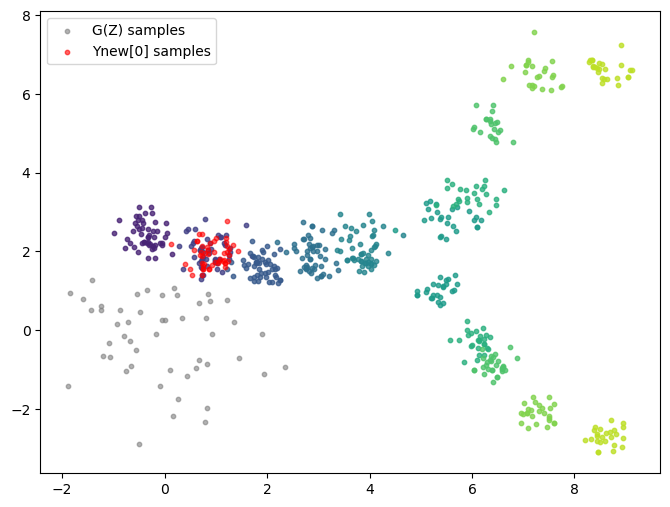

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.close('all')
plt.figure(figsize=(8, 6))

for i in range(len(datasets_acc)):
    col = colors[i]

    # --------- Sample from affine sampler --------- #
    pt_batch = Ysamplers_acc[i].sample(50)
    pt_batch_np = pt_batch.detach().cpu().numpy()

    # Mean of perturbed samples
    mu_pt = pt_batch_np.mean(axis=0)

    # Plot perturbed samples and mean
    plt.scatter(pt_batch_np[:, 0], pt_batch_np[:, 1], color=col, s=10, alpha=0.8)
    # plt.scatter(*mu_pt, color='black', marker='x', s=40, label='Perturbed μ' if i == 0 else '')

# --------- Generator samples --------- #
Z = Z_sampler.sample(50)              # shape (50, latent_dim)
GZ = Gacc(Z).detach().cpu().numpy()     # shape (50, 2)
plt.scatter(GZ[:, 0], GZ[:, 1], color='grey', s=10, alpha=0.6, label='G(Z) samples')

checkdata = Ysamplers_acc_new[1].sample(50).detach().numpy()
plt.scatter(checkdata[:, 0], checkdata[:, 1], color='red', s=10, alpha=0.6, label='Ynew[0] samples')

plt.legend()
plt.show()


In [11]:
G_loss_history = []

- Estimates the distribution at `age` using Robust Local Fréchet Regression. (You can skip this step, as pre-trained networks are already provided.)

Iteration 75


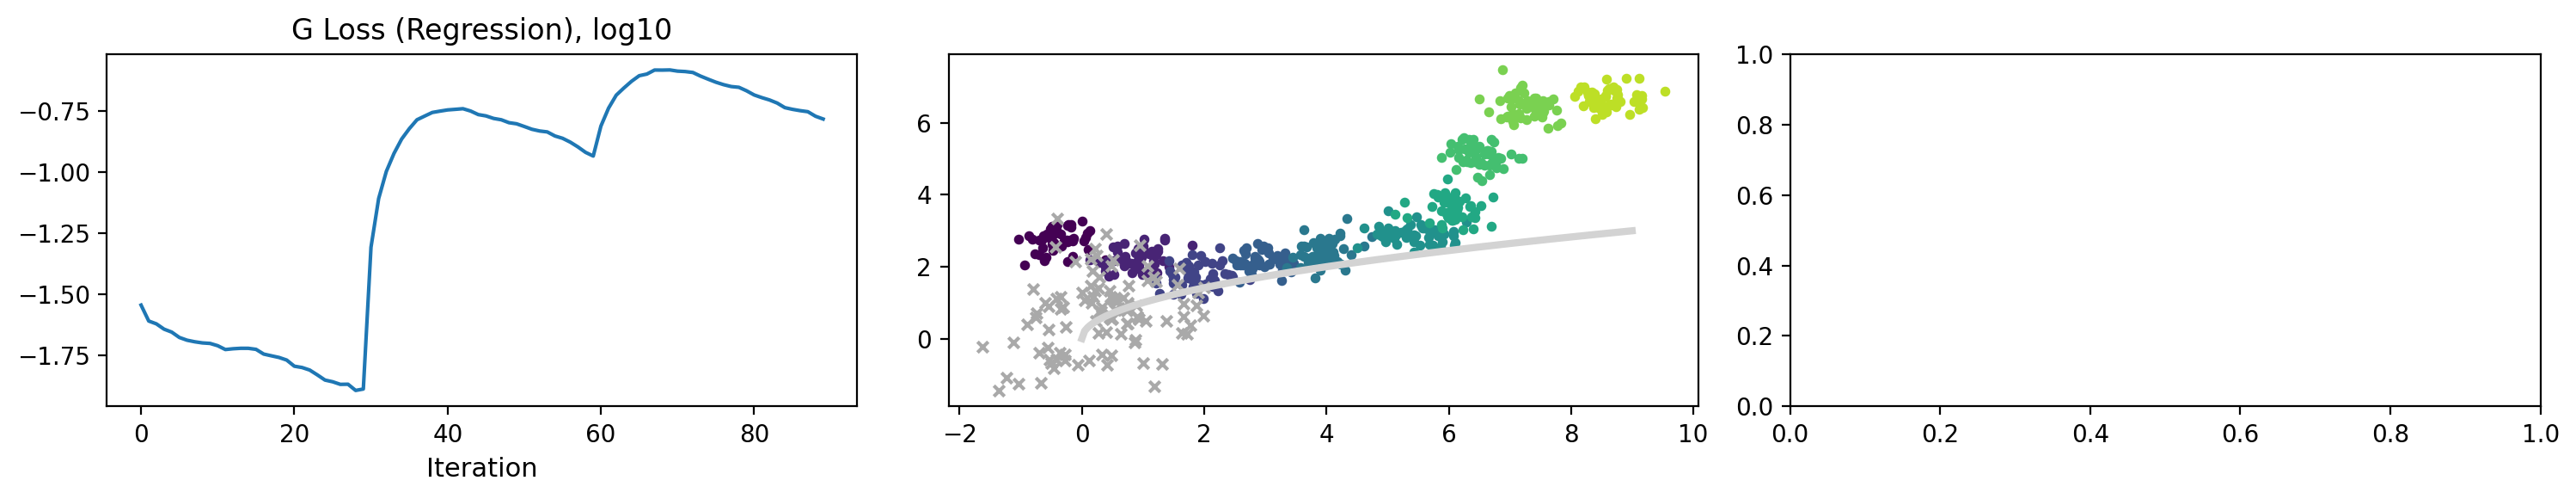

plt!!!!!!!!


  0%|          | 0/25 [00:00<?, ?it/s]

Joint training: total_iters: 75, d_iter: 0


  4%|▍         | 1/25 [00:00<00:05,  4.08it/s]

Joint training: total_iters: 76, d_iter: 1


  8%|▊         | 2/25 [00:00<00:05,  4.11it/s]

Joint training: total_iters: 77, d_iter: 2


 12%|█▏        | 3/25 [00:00<00:05,  4.15it/s]

Joint training: total_iters: 78, d_iter: 3


 16%|█▌        | 4/25 [00:00<00:05,  4.17it/s]

Joint training: total_iters: 79, d_iter: 4


 20%|██        | 5/25 [00:01<00:04,  4.19it/s]

Joint training: total_iters: 80, d_iter: 5


 24%|██▍       | 6/25 [00:01<00:04,  4.22it/s]

Joint training: total_iters: 81, d_iter: 6


 28%|██▊       | 7/25 [00:01<00:04,  4.23it/s]

In [ ]:
# some parameters
MAX_ITER = 200000

# joint training T, then train the network distributedly
BATCH_SIZE = 32
BATCH_SIZE_G = 64

D_ITERS = 25
T_ITERS = 10
G_ITERS = 30

# Main Training Loop
it = 0 # number of iterations
G_time = 0 # numbers of G updating
loss_at_start = 0
start_losses = [] # a list of the first G_losses after updating T

while it < MAX_ITER:

    G_time += 1

    # Optimize T and D
    it = optimize_T_and_D_UOT_new(it, Gacc, Tacc, Dacc, Tacc_opt, Dacc_opt, Z_sampler, Ysamplers_acc_new, NUM, DIM, BATCH_SIZE, ALPHAS_LF_new, D_ITERS, T_ITERS, tau=5)

    loss_at_start = optimize_G(Gacc, Tacc, Gacc_opt, Z_sampler, ALPHAS_LF_new, NUM, DIM, G_ITERS, BATCH_SIZE_G, G_loss_history)
    start_losses.append(loss_at_start)

    # Plot metrics
    # Plotting
    if True:
        clear_output(wait=True)
        print('Iteration', it)

        # Plotting Metrics
        fig, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=200)

        axes[0].set_title('G Loss (Regression), log10', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        axes[0].plot(np.log10(ewma(G_loss_history, span=10)))

        fig.tight_layout(); plt.show(); plt.close(fig)

        print("plt!!!!!!!!")

    # Plotting
    if True:
        clear_output(wait=True)
        print('Iteration', it)
        last_plot_it = it

        # Plotting Metrics
        fig, axes = plt.subplots(1, 3, figsize=(15, 3), dpi=200)

        axes[0].set_title('G Loss (Regression), log10', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        axes[0].plot(np.log10(ewma(G_loss_history, span=10)))

        # visualize population 
        Z = Z_sampler.sample(100)
        GZ = Gacc(Z).detach().numpy()

        # Plot y = sqrt(x) with a light grey line
        axes[1].plot(x_fine, y_fine, color='lightgrey', linewidth=3)
        for i, sampled_data in enumerate(datasets_acc):
            axes[1].scatter(sampled_data[:50, 0], sampled_data[:50, 1],
                        color=viridis(Normalize(0, 10)(i)), s=10)

        axes[1].scatter(GZ[:, 0], GZ[:, 1], color='darkgrey', s=20, marker='x', label="New Data")

        fig.tight_layout(); plt.show(); plt.close(fig)

        print("plt!!!!!!!!")

    # Early stopping or checkpoint saving
    if G_time > 100:
        break

- After training, you can save the learned distribution `G` to your specified directory.
- To save time, we also provide trained networks to proceed with the subsequent steps.

In [ ]:
# save the result 
# save_path = "/Path/to/your/folder/results/"
# torch.save(Gacc.state_dict(), save_path+"G_100_acc_1.pth")